# **MCMC with PAM Approximation**


## Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, gamma
from scipy.special import factorial

# For reproducibility (optional)
np.random.seed(42)


## Data and Parameters


In [2]:
#####################################
# Data (Influenza in Wales or custom)
#####################################

Y = np.array([
    [0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],
    [73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],
    [3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],
    [0,1,4,6],[0,1,3,0],[2,1,7,1],[1,1,6,2]
])

h   = 1/7
pho = 2/3
g   = 2/3
R   = 19
T   = 7*R


## Define Helpers (Truncated Normal, etc.)


In [3]:
def get_truncated_normal(mean, sd, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


## PAL-Related Functions


In [4]:
def K(k, betas):
    """
    Transition matrix K for compartment k given betas.
    """
    K_mat = np.zeros((4,4))
    K_mat[0, 0], K_mat[0, 1] = np.exp(-betas[k]*h), 1 - np.exp(-betas[k]*h)
    K_mat[1, 1], K_mat[1, 2] = np.exp(-h*pho), 1 - np.exp(-h*pho)
    K_mat[2, 2], K_mat[2, 3], K_mat[3, 3] = np.exp(-h*g), 1 - np.exp(-h*g), 1
    return K_mat

def calcul(Y_val, G, P, Q):
    """
    Helper function used in the PAL code 
    to reassign zeros and compute M = Y*G*(P/Q).
    """
    Q_new = Q.copy()
    for s in np.argwhere(Q_new == 0):
        if Y_val[s[0]][s[1]]==0 or G[s[0]][s[1]]==0 or P[s[0]][s[1]]==0:
             Q_new[s[0]][s[1]] = 1
    M = np.multiply(Y_val, np.multiply(G, np.divide(P, Q_new, out=np.zeros_like(P), where=(Q_new!=0))))
    for s in np.argwhere(Q_new == 0):
        M[s[0]][s[1]] = 0
    return M

def log_factorial(Y_val):
    """
    Basic log-factorial in a 4x4 matrix. 
    Here, for demonstration, we do it mostly for (1,2).
    """
    M = np.zeros((4,4))
    val = Y_val[1,2]
    if val>1:
        # sum(log(1..val))
        M[1,2] = np.sum(np.log(np.arange(1, val+1)))
    return M

# Initial states (for each compartment)
X1 = np.array([948, 0, 1, 0])
X2 = np.array([1689, 0, 1, 0])
X3 = np.array([3466, 0, 1, 0])
X4 = np.array([1894, 0, 1, 0])

def PAL(y, theta, R=19):
    """
    Core function that, at each time r in [0..R-1],
    computes partial log-likelihood for each compartment k
    using a Poisson-like approximation approach.
    """
    #  X shape = (4,4)
    X = np.array([X1, X2, X3, X4]) 
    B = theta[:16].reshape(4,4)  # first 16 are "matrix" parameters
    L = np.zeros((R, 4))         # partial log-likelihood, shape (R,4)

    for r_i in range(R):
        G = np.zeros((7, 4, 4, 4))
        # 6 steps of accumulation
        for i in range(6):
            I = X[:, 2]
            betas = 1/8000 * np.dot(B, I)
            for k in range(4):
                G[i][k] = np.multiply(np.outer(np.ones(4), X[k]), K(k, betas))
                # row-sum:
                X[k] = np.dot(np.ones(4), G[i][k])

        # final step i=6
        I = X[:, 2]
        betas = 1/8000 * np.dot(B, I)
        for k in range(4):
            G[6][k] = np.multiply(np.outer(np.ones(4), X[k]), K(k, betas))
            M = np.zeros((4,4))
            Q = np.zeros((4,4))
            # param link for data
            Q[1][2] = theta[k+16]
            for i in range(7):
                M += np.multiply(G[i][k], Q)
            # Observed data Y_bar
            Y_bar = np.zeros((4,4))
            Y_bar[1][2] = y[r_i][k]

            G_bar = np.multiply(np.outer(np.ones(4), np.ones(4))-Q, G[i][k]) \
                    + calcul(Y_bar, G[6][k], Q, M)

            X[k] = np.dot(np.ones(4), G_bar)  # row-sum

            # log-likelihood contribution
            sumM = np.dot(np.ones(4), np.dot(M, np.ones(4)))  # sum of M
            # be careful with log of M - add small constant if needed
            logM = np.dot(np.ones(4),
                          np.dot(Y_bar * np.log(M + 1e-12), np.ones(4)))
            lf = np.dot(np.ones(4),
                        np.dot(log_factorial(Y_bar), np.ones(4)))

            L[r_i][k] = -sumM + logM - lf

    return L

def log_PAL(y, theta, R=19):
    """
    Summation across time steps for each compartment.
    """
    partials = PAL(y, theta, R)
    # partials shape: (R,4)
    for r_i in range(1, R):
        partials[r_i] += partials[r_i-1]
    return partials

def log_prior(theta):
    """
    Product of Gamma pdf for first 16, truncated normal for last 4.
    """
    prior_val = 1.0
    for i in range(16):
        # gamma.pdf(x, a=shape, scale=1 => rate=1)
        prior_val *= gamma.pdf(theta[i], a=5, scale=1)
    for i in range(4):
        prior_val *= truncnorm.pdf(theta[16+i], a=0, b=1, loc=0.5, scale=0.5)
    if prior_val == 0:
        return -1e7  # large penalty
    return np.log(prior_val + 1e-12)

def logL_PAL(y, theta, R=19):
    """
    Final 4D log-likelihood vector plus prior => shape(4,)
    """
    L_cumul = log_PAL(y, theta, R)  # shape (R,4)
    # The last row => sum of partial contributions
    L_vec = L_cumul[-1, :]
    return L_vec + log_prior(theta)

def PAL_loglike(y, theta, R=19):
    """
    Single scalar = sum of compartments + prior
    """
    return np.sum(logL_PAL(y, theta, R))


## MCMC Sampler (Metropolis-Hastings) with PAL


In [5]:
def MCMC_PAL(y, N, R=19):
    """
    Simple Metropolis-Hastings using the PAL-based log-likelihood.
    We'll store and return shape: (N, 20).
    """
    # 1) Initialize theta from the prior
    theta_init = np.concatenate([
        np.random.gamma(5, 1, 16),
        get_truncated_normal(mean=0.5, sd=0.5, low=0, upp=1).rvs(4)
    ])
    # 2) Evaluate log-likelihood
    L_init = PAL_loglike(y, theta_init, R=R)
    
    # store chain
    dim_theta = len(theta_init)
    thetas = np.zeros((N, dim_theta))
    thetas[0] = theta_init
    loglikes = np.zeros(N)
    loglikes[0] = L_init
    
    # 3) MCMC loop
    for n in range(1, N):
        # propose
        # for first 16 => gamma block ~ truncated(0, inf)
        # for last 4 => truncated(0,1)
        # We'll do a random-walk around the current theta.
        curr_theta = thetas[n-1].copy()
        theta_new = curr_theta.copy()
        
        # Propose update for the first 16 (Gamma)
        new_block_16 = get_truncated_normal(
            mean=curr_theta[:16], sd=0.2, low=0, upp=np.inf
        ).rvs()
        
        # Propose update for the last 4 (Trunc Norm[0,1])
        new_block_4 = get_truncated_normal(
            mean=curr_theta[16:], sd=0.2, low=0, upp=1
        ).rvs()
        
        theta_new[:16] = new_block_16
        theta_new[16:] = new_block_4
        
        # Evaluate new log-likelihood
        L_new = PAL_loglike(y, theta_new, R=R)
        
        # Acceptance
        alpha = L_new - loglikes[n-1]  # difference in log posterior
        if np.log(np.random.rand()) < alpha:
            # accept
            thetas[n] = theta_new
            loglikes[n] = L_new
        else:
            # reject
            thetas[n] = curr_theta
            loglikes[n] = loglikes[n-1]
    
    return thetas, loglikes


## Run the MCMC


In [6]:
# Number of MCMC iterations
N_iter = 2000

print("Running MCMC with PAL approximation...")
thetas_chain, loglikes_chain = MCMC_PAL(Y, N_iter, R=19)
print("Done.")

print("Shape of thetas:", thetas_chain.shape)
print("Shape of log-likelihoods:", loglikes_chain.shape)


Running MCMC with PAL approximation...
Done.
Shape of thetas: (2000, 20)
Shape of log-likelihoods: (2000,)


## Plots (Parameter Traces)


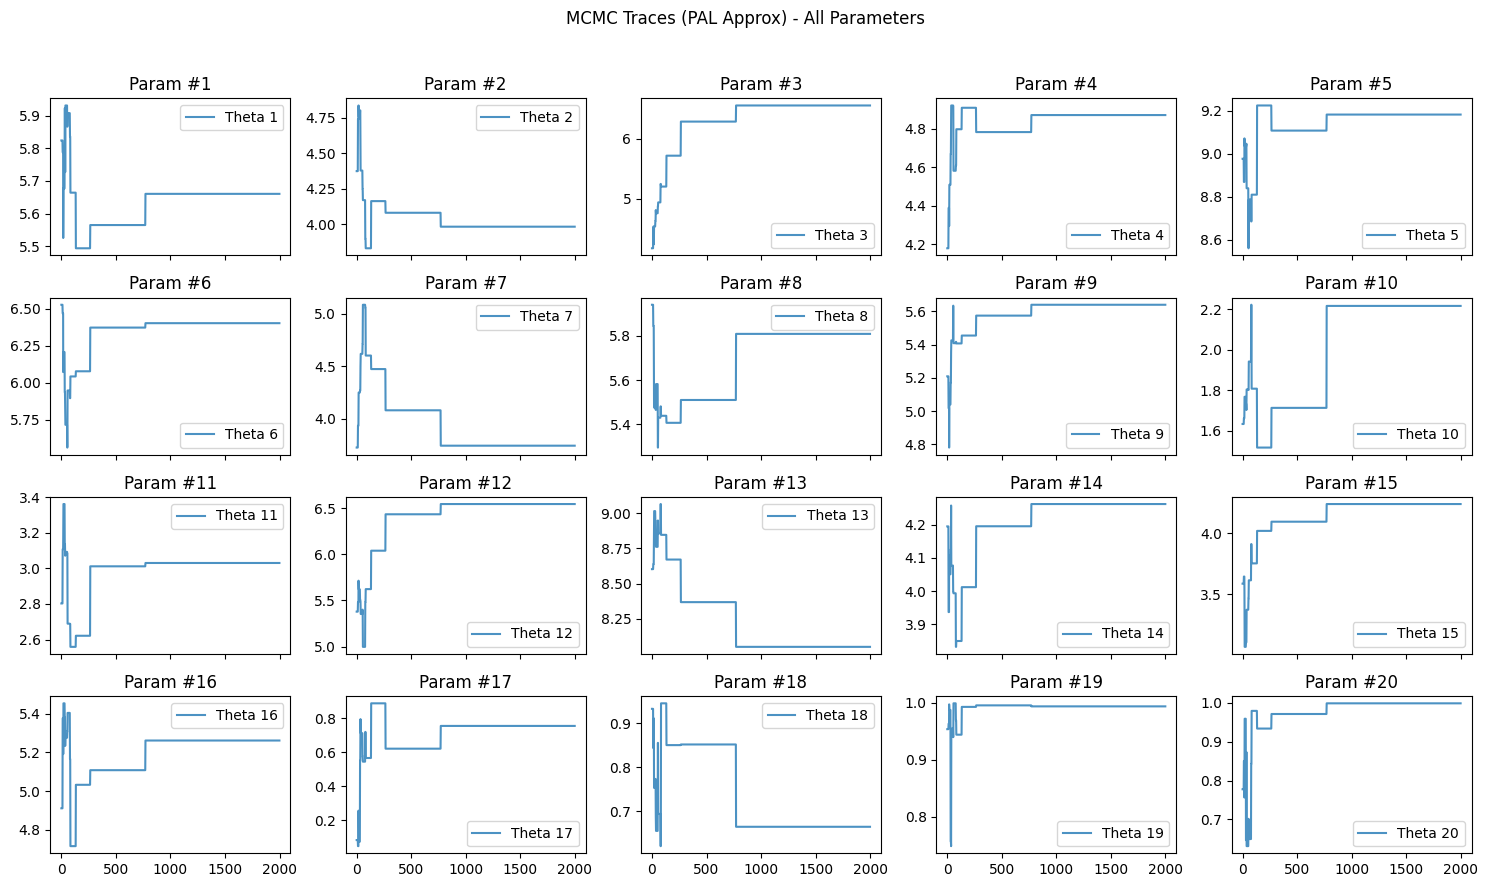

In [7]:
dim_theta = thetas_chain.shape[1]
iterations = np.arange(N_iter)

# Plot a subset of parameters or all of them
# For instance, let's just do the first 6 for a quick look,
# or do all in a grid (4 x 5) for 20 parameters.

nrow, ncol = 4, 5
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 9), sharex=True)
axes = axes.flatten()

for i in range(dim_theta):
    ax = axes[i]
    ax.plot(iterations, thetas_chain[:, i], label=f"Theta {i+1}", alpha=0.8)
    ax.set_title(f"Param #{i+1}")
    ax.legend(loc='best')

# If fewer than 20, remove extra subplots
for j in range(dim_theta, nrow*ncol):
    fig.delaxes(axes[j])

plt.suptitle("MCMC Traces (PAL Approx) - All Parameters")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


## Plot the Log-Likelihood Trace


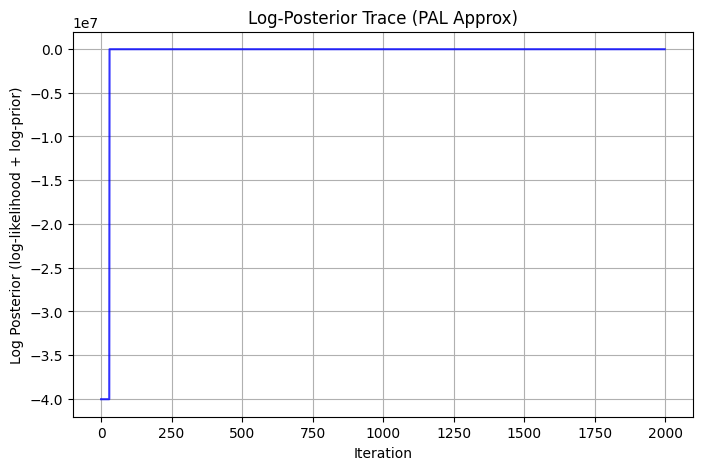

In [8]:
plt.figure(figsize=(8,5))
plt.plot(iterations, loglikes_chain, 'b-', alpha=0.8)
plt.title("Log-Posterior Trace (PAL Approx)")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior (log-likelihood + log-prior)")
plt.grid(True)
plt.show()


## Posterior Histograms or Print Summaries


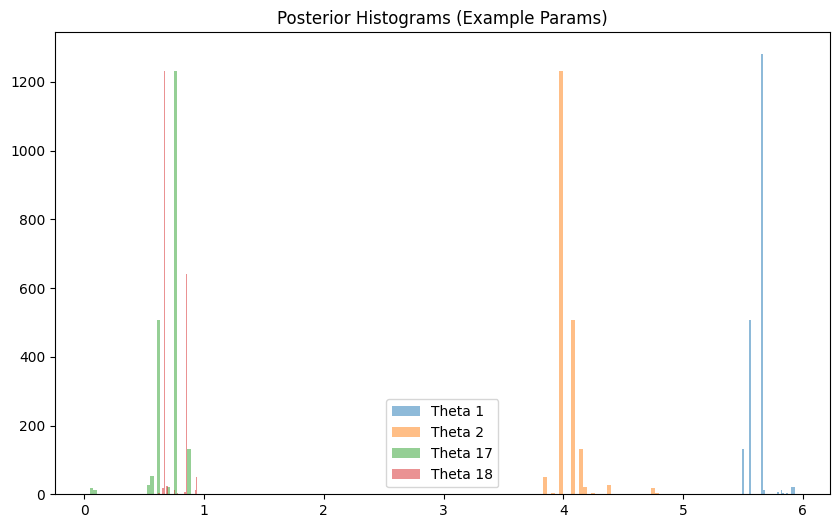

Param 1: mean=5.6328, std=0.0719
Param 2: mean=4.0339, std=0.1125
Param 3: mean=6.3174, std=0.4460
Param 4: mean=4.8387, std=0.0812
Param 5: mean=9.1448, std=0.0900
Param 6: mean=6.3506, std=0.1292
Param 7: mean=3.9290, std=0.2858
Param 8: mean=5.6875, std=0.1600
Param 9: mean=5.5903, std=0.0927
Param 10: mean=2.0164, std=0.2604
Param 11: mean=2.9842, std=0.1307
Param 12: mean=6.4094, std=0.2919
Param 13: mean=8.2241, std=0.2495
Param 14: mean=4.2106, std=0.0953
Param 15: mean=4.1424, std=0.1806
Param 16: mean=5.1949, std=0.1171
Param 17: mean=0.7115, std=0.1104
Param 18: mean=0.7341, std=0.0943
Param 19: mean=0.9914, std=0.0161
Param 20: mean=0.9764, std=0.0574


In [9]:
# Example: posterior histograms for a few parameters
plt.figure(figsize=(10,6))

for idx in [0, 1, 16, 17]:  # e.g., 2 Gamma params + 2 truncated
    plt.hist(thetas_chain[:, idx], bins=30, alpha=0.5, label=f"Theta {idx+1}")
    
plt.title("Posterior Histograms (Example Params)")
plt.legend()
plt.show()

# Or simply print some stats (means, medians, etc.)
mean_params = np.mean(thetas_chain, axis=0)
std_params  = np.std(thetas_chain, axis=0)

for i in range(dim_theta):
    print(f"Param {i+1}: mean={mean_params[i]:.4f}, std={std_params[i]:.4f}")
